In [24]:
%load_ext autoreload
import neptune.new as neptune
from trainers import timegan_generate_data
from utils import *

np.random.seed(42)
alpha = 0.7
noise = 0
testset = DatasetSinus(num=600, seq_len=100, alpha=alpha, noise=noise)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Models
from architectures.timegan_cnn_DG import *
#from architectures.timegan_cnn_D import *
#from architectures.timegan_cnn_G import *
#from architectures.timegan_cnn_DGER import *
#from architectures.RGAN import *
#from architectures.RTSGAN import *

print(f"Loading architecture: {ID}")

In [6]:
run = neptune.init_run(with_id="TIMEGAN-84",
                       project="kohmann/timeGAN",api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjFjNGY5MS1kOWU1LTRmZjgtOTNiYS0yOGI2NDdjZGYzNWUifQ==",
                       )
params = run["parameters"].fetch()
params["device"] = "cpu"

if "TimeGAN" in ID:
    model = TimeGAN(params)
elif ID == "RGAN":
    model = RGAN(params)
elif ID == "RTSGAN":
    model = RTSGAN(params)
else:
    raise ValueError
model = restore_weights(model, run)

https://app.neptune.ai/kohmann/timeGAN/e/TIMEGAN-84


Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs.neptune.ai/help/nvml_error/


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 5 operations to synchronize with Neptune. Do not kill this process.
All 5 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/kohmann/timeGAN/e/TIMEGAN-84


In [7]:
fake_data = timegan_generate_data(model, torch.tensor(testset.T), params["max_seq_len"], params["Z_dim"])

#### Evaluation methods

https://app.neptune.ai/kohmann/Evaluation/e/EV-2
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


/Users/kohmann/Documents/Studie/2022 Høst/master-GAN/TimeGAN/metrics.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  sins3_fake = torch.tensor(sins3_fake)


MSE Error: 0.00457
Mean Wasserstein/Sinkhorn distance: 0.0121 ± 0.0048
Mean MMD: 0.0112 ± 0.0020


/Users/kohmann/Documents/Studie/2022 Høst/master-GAN/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/kohmann/Documents/Studie/2022 Høst/master-GAN/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
All 2 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/kohmann/Evaluation/e/EV-2


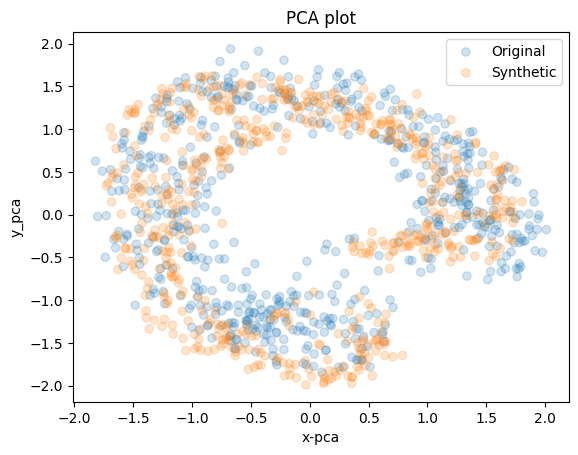

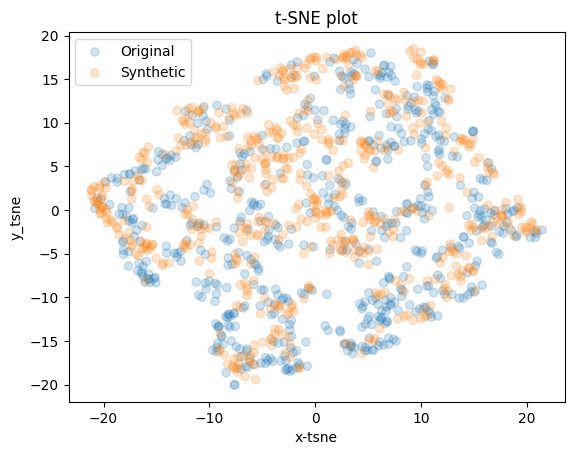

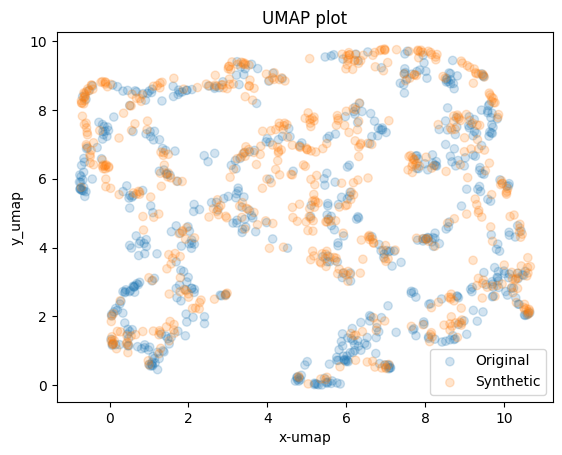

In [12]:
run = neptune.init_run(
    project="kohmann/Evaluation",
    name=ID,
    description="",
    #source_files=["architectures/RTSGAN.py"],
    capture_hardware_metrics=False,
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjFjNGY5MS1kOWU1LTRmZjgtOTNiYS0yOGI2NDdjZGYzNWUifQ==",
)

from metrics import compare_sin3_generation, sinkhorn_distance, MMD
mse_error = compare_sin3_generation(fake_data, 0.7, 0)
print(f"MSE Error: {mse_error:.5f}")
x = torch.tensor(fake_data)
y = testset[:][0]
wass_dist = sinkhorn_distance(x,y)
mmd = MMD(x,y)
print(f"Mean Wasserstein/Sinkhorn distance: {wass_dist.mean():.4f} ± {wass_dist.std():.4f}")
print(f"Mean MMD: {mmd.mean():.4f} ± {mmd.std():.4f}")


run["numeric_results/num_test_samples"] = len(testset)
run["numeric_results/sin3_generation_MSE_loss"] = mse_error
run["numeric_results/wasserstein_distance_mean"] = wass_dist.mean()
run["numeric_results/wasserstein_distance_std"] = wass_dist.std()
run["numeric_results/MMD_mean"] = mmd.std()
run["numeric_results/MMD_std"] = mmd.std()

r = np.array([data[0].numpy() for data in testset])
#sin = None
#f_pca = visualization(r[:,:,sin][:,:,None], fake_data[:,:,sin][:,:,None], 'umap')
run["PCA"].upload(visualization(r, fake_data, 'pca'))
run["tSNE"].upload(visualization(r, fake_data, 'tsne'))
run["UMAP"].upload(visualization(r, fake_data, 'umap'))
run.stop()

ValueError: too many values to unpack (expected 3)

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/kohmann/Evaluation/e/EV-1
